### IMPORTS

In [1]:
!pip install -q scikit-optimize

In [2]:
!pip install category_encoders

In [3]:
!pip install xgboost

In [4]:
import os
import math
import timeit
from collections import Counter
import gc
import pickle

import pandas as pd
import numpy as np
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.impute import SimpleImputer
from sklearn.metrics import roc_auc_score, confusion_matrix, f1_score
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.feature_selection import mutual_info_classif as MIC
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

import category_encoders as ce

from sklearn import metrics, tree
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from IPython.display import display, display_html
import xgboost as xgb

### UDFs

In [5]:
def my_print(s):
    """
    Custom print with timestamp.
    """
    print("[{}] {}".format(datetime.now().strftime('%d/%m/%Y %H:%M:%S'), s))

In [6]:
def get_missing_values(pdf):
        """
        Retorna um Pandas Series com as colunas que tem ao
        menos um missing value.
        """
        
        missing = pdf.isnull().sum()
        return missing[missing > 0]

### LOAD DATA

In [7]:
df = pd.read_csv("Churn Modeling.csv")

In [8]:
df.shape

(10000, 14)

In [9]:
get_missing_values(df)

Series([], dtype: int64)

In [10]:
df

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,9996,15606229,Obijiaku,771,France,Male,39,5,0.00,2,1,0,96270.64,0
9996,9997,15569892,Johnstone,516,France,Male,35,10,57369.61,1,1,1,101699.77,0
9997,9998,15584532,Liu,709,France,Female,36,7,0.00,1,0,1,42085.58,1
9998,9999,15682355,Sabbatini,772,Germany,Male,42,3,75075.31,2,1,0,92888.52,1


In [11]:
df = df.drop(['RowNumber','CustomerId','Surname'], axis=1)

In [12]:
df

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0
...,...,...,...,...,...,...,...,...,...,...,...
9995,771,France,Male,39,5,0.00,2,1,0,96270.64,0
9996,516,France,Male,35,10,57369.61,1,1,1,101699.77,0
9997,709,France,Female,36,7,0.00,1,0,1,42085.58,1
9998,772,Germany,Male,42,3,75075.31,2,1,0,92888.52,1


In [13]:
var_cat = ['Geography','Gender']

In [14]:
var_num = ['CreditScore','Age', 'Tenure', 'Balance','NumOfProducts','EstimatedSalary','HasCrCard','IsActiveMember']

In [15]:
var_target = ['Exited']

In [16]:
features = list(var_cat + var_num)

In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   CreditScore      10000 non-null  int64  
 1   Geography        10000 non-null  object 
 2   Gender           10000 non-null  object 
 3   Age              10000 non-null  int64  
 4   Tenure           10000 non-null  int64  
 5   Balance          10000 non-null  float64
 6   NumOfProducts    10000 non-null  int64  
 7   HasCrCard        10000 non-null  int64  
 8   IsActiveMember   10000 non-null  int64  
 9   EstimatedSalary  10000 non-null  float64
 10  Exited           10000 non-null  int64  
dtypes: float64(2), int64(7), object(2)
memory usage: 859.5+ KB


In [18]:
features

['Geography',
 'Gender',
 'CreditScore',
 'Age',
 'Tenure',
 'Balance',
 'NumOfProducts',
 'EstimatedSalary',
 'HasCrCard',
 'IsActiveMember']

In [19]:
X = df[features]
y = df[var_target]

### Spliting Data

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 0)

In [21]:
len(X), len(X_train), len(X_test), len(y_train), len(y_test)

(10000, 7500, 2500, 7500, 2500)

In [22]:
X_train

,Geography,Gender,CreditScore,Age,Tenure,Balance,NumOfProducts,EstimatedSalary,HasCrCard,IsActiveMember
2967,Germany,Female,579,39,5,117833.30,3,5831.00,0,0
700,France,Female,750,32,5,0.00,2,95611.47,1,0
3481,Spain,Female,729,34,9,53299.96,2,42855.97,1,1
1621,Spain,Male,689,38,5,75075.14,1,8651.92,1,1
800,France,Male,605,52,7,0.00,2,173952.50,1,1
...,...,...,...,...,...,...,...,...,...,...
9225,Germany,Female,594,32,4,120074.97,2,162961.79,1,1
4859,Spain,Female,794,22,4,114440.24,1,107753.07,1,1
3264,France,Male,738,35,5,161274.05,2,181429.87,1,0
9845,Spain,Female,590,38,9,0.00,2,148750.16,1,1


### Categorização

#### Target Enconder
    

In [22]:
target_enconder = ce.TargetEncoder(
    cols=var_cat,
    verbose=10
)
target_enconder.fit(X,y)

C:\ProgramData\Anaconda3\lib\site-packages\category_encoders\target_encoder.py:92: FutureWarning: Default parameter min_samples_leaf will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter min_samples_leaf will change in version 2.6."
C:\ProgramData\Anaconda3\lib\site-packages\category_encoders\target_encoder.py:97: FutureWarning: Default parameter smoothing will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter smoothing will change in version 2.6."


TargetEncoder(cols=['Geography', 'Gender'], verbose=10)

In [23]:
X_train = target_enconder.transform(X_train)
X_test = target_enconder.transform(X_test)

#### OneHot Enconder

In [24]:
onehot_enconder = ce.OneHotEncoder(cols=var_cat)
onehot_enconder.fit(X_train)

OneHotEncoder(cols=['Geography', 'Gender'])

In [25]:
X_train_OHE = onehot_enconder.transform(X_train)
X_test_OHE = onehot_enconder.transform(X_test)

### Padronização

In [26]:
mm_scaler = MinMaxScaler()
X_train_mm = mm_scaler.fit_transform(X_train[var_num])
X_test_mm = mm_scaler.transform(X_test[var_num])

In [27]:
X_train_mm

array([[0.458     , 0.31343284, 0.5       , ..., 0.02909988, 0.        ,
        0.        ],
       [0.8       , 0.20895522, 0.5       , ..., 0.4780451 , 1.        ,
        0.        ],
       [0.758     , 0.23880597, 0.9       , ..., 0.21424241, 1.        ,
        1.        ],
       ...,
       [0.776     , 0.25373134, 0.5       , ..., 0.90717809, 1.        ,
        0.        ],
       [0.48      , 0.29850746, 0.9       , ..., 0.74376393, 1.        ,
        1.        ],
       [0.546     , 0.44776119, 0.1       , ..., 0.59427515, 1.        ,
        0.        ]])

In [28]:
ss = StandardScaler()
X_train_ss = ss.fit_transform(X_train[var_num])
X_test_ss = ss.transform(X_test[var_num])

In [30]:
X_train_ss

array([[-0.73550706,  0.01526571,  0.00886037, ..., -1.64080994,
        -1.55362351, -1.03446007],
       [ 1.02442719, -0.65260917,  0.00886037, ..., -0.07927152,
         0.64365658, -1.03446007],
       [ 0.80829492, -0.46178778,  1.39329338, ..., -0.99684012,
         0.64365658,  0.96668786],
       ...,
       [ 0.90092304, -0.36637708,  0.00886037, ...,  1.4133552 ,
         0.64365658, -1.03446007],
       [-0.62229491, -0.08014499,  1.39329338, ...,  0.84496184,
         0.64365658,  0.96668786],
       [-0.28265848,  0.87396199, -1.37557264, ...,  0.32500428,
         0.64365658, -1.03446007]])

### Final Dataset

In [31]:
X_train_scaled = pd.DataFrame(X_train_ss, index = X_train[var_num].index, columns = X_train[var_num].columns)
X_test_scaled = pd.DataFrame(X_test_ss, index = X_test[var_num].index, columns = X_test[var_num].columns)

In [32]:

X_test_scaled 

,CreditScore,Age,Tenure,Balance,NumOfProducts,EstimatedSalary,HasCrCard,IsActiveMember
9394,-0.550251,-0.366377,1.047185,0.884943,-0.926551,1.612030,0.643657,0.966688
898,-1.311860,0.110676,-1.029464,0.435867,-0.926551,0.496269,0.643657,-1.034460
2398,0.571579,0.301498,1.047185,0.314864,-0.926551,-0.425028,0.643657,0.966688
5906,1.415524,-0.652609,-0.337248,0.581318,-0.926551,-0.187853,-1.553624,-1.034460
2343,0.571579,-0.080145,0.008860,1.394678,0.804242,0.617324,0.643657,0.966688
...,...,...,...,...,...,...,...,...
8764,1.261143,1.160194,1.047185,0.647051,0.804242,-0.234243,0.643657,0.966688
4359,-1.085436,0.492319,-1.029464,0.828044,-0.926551,0.143134,0.643657,-1.034460
2041,1.950708,0.015266,-1.375573,0.308194,-0.926551,-0.272747,0.643657,-1.034460
1108,0.293694,-0.080145,0.701077,0.556988,0.804242,-0.933066,0.643657,-1.034460


In [34]:
X_train[var_cat]

,Geography,Gender
2967,0.324432,0.250715
700,0.161548,0.250715
3481,0.166734,0.250715
1621,0.166734,0.164559
800,0.161548,0.164559
...,...,...
9225,0.324432,0.250715
4859,0.166734,0.250715
3264,0.161548,0.164559
9845,0.166734,0.250715


In [35]:
Xs_train = pd.concat([X_train_scaled, X_train[var_cat]], axis=1)
Xs_test = pd.concat([X_test_scaled, X_test[var_cat]], axis=1)

In [36]:
Xs_test

,CreditScore,Age,Tenure,Balance,NumOfProducts,EstimatedSalary,HasCrCard,IsActiveMember,Geography,Gender
9394,-0.550251,-0.366377,1.047185,0.884943,-0.926551,1.612030,0.643657,0.966688,0.324432,0.250715
898,-1.311860,0.110676,-1.029464,0.435867,-0.926551,0.496269,0.643657,-1.034460,0.161548,0.250715
2398,0.571579,0.301498,1.047185,0.314864,-0.926551,-0.425028,0.643657,0.966688,0.166734,0.250715
5906,1.415524,-0.652609,-0.337248,0.581318,-0.926551,-0.187853,-1.553624,-1.034460,0.161548,0.164559
2343,0.571579,-0.080145,0.008860,1.394678,0.804242,0.617324,0.643657,0.966688,0.324432,0.164559
...,...,...,...,...,...,...,...,...,...,...
8764,1.261143,1.160194,1.047185,0.647051,0.804242,-0.234243,0.643657,0.966688,0.324432,0.164559
4359,-1.085436,0.492319,-1.029464,0.828044,-0.926551,0.143134,0.643657,-1.034460,0.324432,0.250715
2041,1.950708,0.015266,-1.375573,0.308194,-0.926551,-0.272747,0.643657,-1.034460,0.161548,0.250715
1108,0.293694,-0.080145,0.701077,0.556988,0.804242,-0.933066,0.643657,-1.034460,0.324432,0.164559


In [37]:
y_train = y_train.Exited
y_test = y_test.Exited

In [38]:
y_train

2967    1
700     0
3481    0
1621    1
800     0
       ..
9225    0
4859    0
3264    0
9845    0
2732    1
Name: Exited, Length: 7500, dtype: int64

### Regressão Logística

In [39]:
stime = timeit.default_timer()
clr = LogisticRegression(random_state=45678, solver='lbfgs', n_jobs=-1, penalty = "none")
clr.fit(Xs_train, y_train)

etime = timeit.default_timer()
lr_baseline_time = etime - stime
print(f'Speed: {lr_baseline_time:.2f}s')
print(f'AUC train: {metrics.roc_auc_score(y_train, clr.predict_proba(Xs_train)[:, 1]):.2f}')
print(f'AUC test: {metrics.roc_auc_score(y_test, clr.predict_proba(Xs_test)[:, 1]):.2f}')
print(f'ACC train: {metrics.accuracy_score(y_train, clr.predict(Xs_train)):.2f}')
print(f'ACC test: {metrics.accuracy_score(y_test, clr.predict(Xs_test)):.2f}')
print(f'f1 score train: {metrics.f1_score(y_train, clr.predict(Xs_train)):.2f}')
print(f'f1 score test: {metrics.f1_score(y_test, clr.predict(Xs_test)):.2f}')

Speed: 1.57s
AUC train: 0.77
AUC test: 0.77
ACC train: 0.81
ACC test: 0.81
f1 score train: 0.31
f1 score test: 0.33


In [48]:
y_pred = clr.predict(Xs_train)

In [49]:
conma = metrics.confusion_matrix(y_test, clr.predict(Xs_test))
conma

array([[1905,   86],
       [ 393,  116]], dtype=int64)

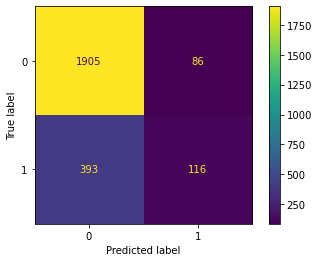

In [51]:
metrics.ConfusionMatrixDisplay(conma).plot()

#### Cross Validation

In [63]:
scores = cross_val_score(clr, Xs_train, y_train, cv =10)
AUC = cross_val_score(clr, Xs_train, y_train, cv =10, scoring = 'roc_auc')
f1 = cross_val_score(clr, Xs_train, y_train, cv =10, scoring = 'f1')

In [64]:
scorings = ['f1', 'accuracy', 'roc_auc']

In [65]:
f1 = cross_validate(clr, Xs_train, y_train, cv =10, scoring = scorings)

In [66]:
sorted(f1.keys())

['fit_time', 'score_time', 'test_accuracy', 'test_f1', 'test_roc_auc']

In [67]:
y_pred = clr.predict(Xs_test)

In [68]:
AUC.mean()

0.7631182183684271

In [61]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.83      0.96      0.89      1991
           1       0.57      0.23      0.33       509

    accuracy                           0.81      2500
   macro avg       0.70      0.59      0.61      2500
weighted avg       0.78      0.81      0.77      2500



### Random Forest

In [72]:
stime = timeit.default_timer()

rf_clf = RandomForestClassifier(
    n_estimators=294,
    criterion='entropy',
    max_depth=10,
    min_samples_split = 7,
    min_samples_leaf = 4,
    max_samples = 0.673861043631317,
    max_features='sqrt',
    random_state= 0
)

rf_clf.fit(Xs_train, y_train)

etime = timeit.default_timer()

rf_clf_baseline_time = etime - stime
rf_clf_y_train_predict = rf_clf.predict_proba(Xs_train)[:, 1]

print(f'Speed: {rf_clf_baseline_time:.2f}s')
print(f'AUC train: {roc_auc_score(y_train, rf_clf_y_train_predict):.2f}')
print(f'AUC test: {metrics.roc_auc_score(y_test, rf_clf.predict_proba(Xs_test)[:, 1]):.2f}')
print(f'f1 score train: {metrics.f1_score(y_train, rf_clf.predict(Xs_train)):.2f}')
print(f'f1 score test: {metrics.f1_score(y_test, rf_clf.predict(Xs_test)):.2f}')

Speed: 1.68s
AUC train: 0.94
AUC test: 0.88
f1 score train: 0.64
f1 score test: 0.60


In [73]:
conma = metrics.confusion_matrix(y_test, rf_clf.predict(Xs_test))
conma

array([[1922,   69],
       [ 264,  245]], dtype=int64)

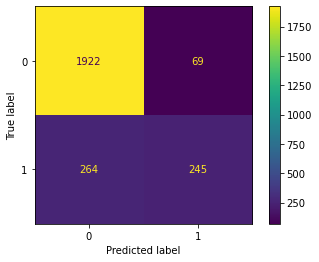

In [74]:
metrics.ConfusionMatrixDisplay(conma).plot()

### Gradient Boosting

In [77]:
gbc = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0,
...     max_depth=2, random_state=0).fit(Xs_train, y_train)
>>> gbc.score(Xs_test, y_test)
gb_clf_y_train_predict = gbc.predict_proba(Xs_train)[:, 1]

print(f'AUC train: {roc_auc_score(y_train, gb_clf_y_train_predict):.2f}')
print(f'AUC test: {metrics.roc_auc_score(y_test, gbc.predict_proba(Xs_test)[:, 1]):.2f}')
print(f'ACC train: {metrics.accuracy_score(y_train, gbc.predict(Xs_train)):.2f}')
print(f'ACC test: {metrics.accuracy_score(y_test, gbc.predict(Xs_test)):.2f}')
print(f'f1 score train: {metrics.f1_score(y_train, gbc.predict(Xs_train)):.2f}')
print(f'f1 score test: {metrics.f1_score(y_test, gbc.predict(Xs_test)):.2f}')

AUC train: 0.92
AUC test: 0.85
ACC train: 0.89
ACC test: 0.86
f1 score train: 0.69
f1 score test: 0.60


### XGBoosting

In [78]:
classificador_xgb = xgb.XGBClassifier()

In [79]:
type(classificador_xgb)

xgboost.sklearn.XGBClassifier

In [80]:
from sklearn.model_selection import cross_val_score

resultado_cv = cross_val_score(classificador_xgb, Xs_train, y_train)
resultado_cv

array([0.846     , 0.85266667, 0.84733333, 0.848     , 0.85466667])

In [81]:
resultado_cv.mean()

0.8497333333333333

In [82]:
classificador_xgb_tunado = xgb.XGBClassifier(max_depth=2, eta= 0.35)
100 * cross_val_score(classificador_xgb_tunado, Xs_train, y_train).mean()

86.32

In [83]:
classificador_xgb_dart = xgb.XGBClassifier(booster='dart')
100 * cross_val_score(classificador_xgb_dart, Xs_train, y_train).mean()

84.97333333333333

In [84]:
classificador_xgb_gblinear = xgb.XGBClassifier(booster='gblinear')
100 * cross_val_score(classificador_xgb_gblinear, Xs_train, y_train).mean()

81.16

In [85]:
classificador_campeao = classificador_xgb_tunado

In [86]:
classificador_campeao.fit(Xs_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False, eta=0.35,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.349999994, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=2, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, ...)

In [87]:
xgb_y_train_predict = classificador_campeao.predict_proba(Xs_train)[:, 1]


print(f'AUC train: {roc_auc_score(y_train, xgb_y_train_predict):.2f}')
print(f'AUC test: {metrics.roc_auc_score(y_test, classificador_campeao.predict_proba(Xs_test)[:, 1]):.2f}')
print(f'ACC train: {metrics.accuracy_score(y_train, classificador_campeao.predict(Xs_train)):.2f}')
print(f'ACC test: {metrics.accuracy_score(y_test, classificador_campeao.predict(Xs_test)):.2f}')
print(f'f1 score train: {metrics.f1_score(y_train, classificador_campeao.predict(Xs_train)):.2f}')
print(f'f1 score test: {metrics.f1_score(y_test, classificador_campeao.predict(Xs_test)):.2f}')

AUC train: 0.89
AUC test: 0.87
ACC train: 0.87
ACC test: 0.87
f1 score train: 0.62
f1 score test: 0.61


In [88]:
conma = metrics.confusion_matrix(y_test, classificador_campeao.predict(Xs_test))
conma

array([[1897,   94],
       [ 242,  267]], dtype=int64)

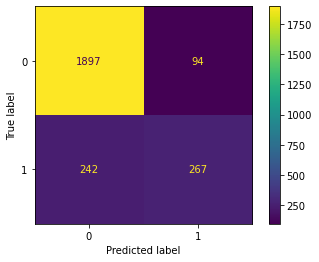

In [89]:
metrics.ConfusionMatrixDisplay(conma).plot()

### Naive Bayes

In [151]:
from sklearn.naive_bayes import GaussianNB
gnb = GaussianNB()

In [153]:
gnb.fit(Xs_train, y_train)
gnb_y_train_predict = gnb.predict_proba(Xs_train)[:, 1]


print(f'AUC train: {roc_auc_score(y_train, gnb_y_train_predict):.2f}')
print(f'AUC test: {metrics.roc_auc_score(y_test, gnb.predict_proba(Xs_test)[:, 1]):.2f}')
print(f'ACC train: {metrics.accuracy_score(y_train, gnb.predict(Xs_train)):.2f}')
print(f'ACC test: {metrics.accuracy_score(y_test, gnb.predict(Xs_test)):.2f}')
print(f'f1 score train: {metrics.f1_score(y_train, gnb.predict(Xs_train)):.2f}')
print(f'f1 score test: {metrics.f1_score(y_test, gnb.predict(Xs_test)):.2f}')

AUC train: 0.80
AUC test: 0.80
ACC train: 0.83
ACC test: 0.83
f1 score train: 0.43
f1 score test: 0.46


In [155]:
conma = metrics.confusion_matrix(y_test, gnb.predict(Xs_test))
conma

array([[1877,  114],
       [ 323,  186]], dtype=int64)

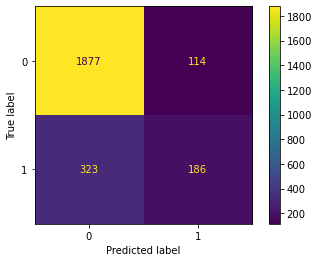

In [156]:
metrics.ConfusionMatrixDisplay(conma).plot()

### Otimização de Hiperparâmetros

In [197]:
from sklearn.model_selection import GridSearchCV
# mudar de acordo com o modelo encontrado
pipeline = GridSearchCV(classificador_xgb, hiperparameters)
hiperparameters = {'booster':('gblinear', 'dart', 'gbtree')}
pipeline.fit(Xs_train, y_train)
pipeline.best_params_
pipeline

GridSearchCV(estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     gamma=None, gpu_id=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None, max_bin=None,
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                       

### Novo Cliente

In [ ]:
#NOVO CLIENTE
#QUAIS SERIAM OS DEFAULT VALUES CASO O CLIENTE NÃO FORNEÇA ALGUM DADO? SERIA A MÉDIA?

CreditScore =  
Age = 
Tenure = 
Balance = 
NumOfProducts = 
HasCrCard = 
IsActiveMember =
EstimatedSalary = 
Geography = 
Gender = 

Parametro = [[CreditScore, Age, Tenure, Balance, NumOfProducts, HasCrCard, IsActiveMember, EstimatedSalary, Geography, Gender]]

Fazendo_Previsao = funcao_logistica.predict(Parametro)
Probabilidade = funcao_logistica.predict_proba(Parametro)

if Fazendo_Previsao == 0:
    print('Retenção')
    print(Probabilidade)
    
else:
    print('Churn')
    print(Probabilidade)